In [105]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.multitest import multipletests

In [106]:
sentiments = pd.read_csv("combined_sentiments2.csv")

pd.set_option('display.float_format', '{:.8f}'.format)

emotions = ['anger', 'fear', 'disgust', 'sadness', 'joy', 'none']
emotions_a = ['anger', 'fear', 'disgust', 'sadness', 'joy', 'none']
emotions_p = ['anger', 'fear', 'disgust', 'sadness', 'joy', 'none']

def label_p(p):
    if p <= 0.001:
        return "p <= .001"
    elif p <= 0.01:
        return "p <= .01"
    elif p <= 0.05:
        return "p <= .05"
    elif p > 0.05 and p < 0.1:
        return "p > .05"
    else:
        return "p > .1"
    
print(len(sentiments))

132121


Optional Adaptations

In [107]:
#U-Scale detected in original data
#-> transform scale to make it more normal

epsilon = 1e-6

for e in emotions:
    sentiments[f"{e}_p"] = np.log((sentiments[f"{e}_p"] + epsilon) / (1 - sentiments[f"{e}_p"] + epsilon))
    sentiments[f"{e}_a"] = np.log((sentiments[f"{e}_a"] + epsilon) / (1 - sentiments[f"{e}_a"] + epsilon))
print(len(sentiments))

132121


In [108]:
#detect and remove highly influential posts

all_influential_obs = set()

for e in emotions:
    dep_var = f"{e}_p"
    predictors = [f"{x}_a" for x in emotions]

    formula = dep_var + " ~ C(NewsroomTopic)"
    for var in predictors:
        formula += " + " + var

    model = ols(formula, data=sentiments).fit()

    influence = model.get_influence()
    cooks_distance, _ = influence.cooks_distance

    n_obs = len(cooks_distance)
    threshold = 4 / n_obs

    influential_obs = [i for i, c in enumerate(cooks_distance) if c > threshold]
    all_influential_obs.update(influential_obs)

sentiments = sentiments.drop(index=list(all_influential_obs))
print(len(sentiments))

110628


In [109]:
#check variance inflation factor of covariates
#high values suggest high influence on other covariates 

cols = []
for e in emotions:
    cols.append(f"{e}_a")
X = sentiments[cols].dropna()
vif_values = []
for i in range(X.shape[1]):
    vif_i = variance_inflation_factor(X.values, i)
    vif_values.append(vif_i)
vif = pd.DataFrame({
    "Variable": X.columns,
    "VIF": vif_values
})
print(vif)

#remove covariates with highest collinearity and lowest appearance in the data
emotions_a = ['anger', 'fear', 'none']

    Variable         VIF
0    anger_a 17.28539587
1     fear_a 11.78760009
2  disgust_a 57.07368222
3  sadness_a 47.23538739
4      joy_a 77.48058116
5     none_a 31.60212663


Pretesting

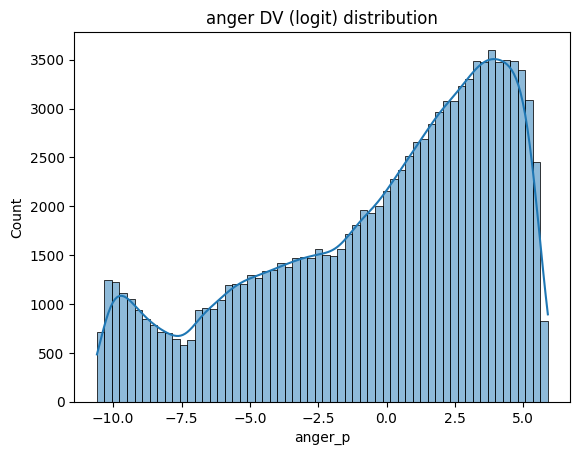

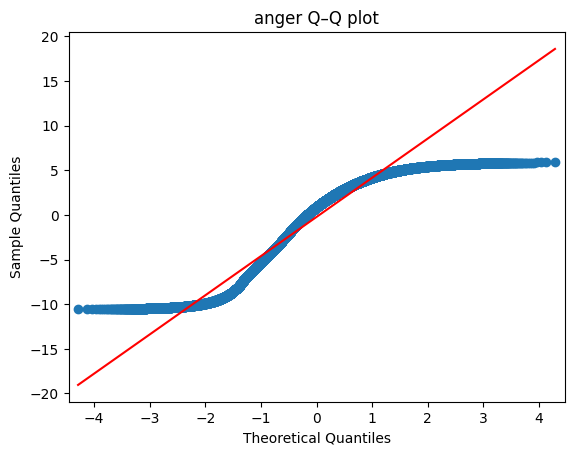

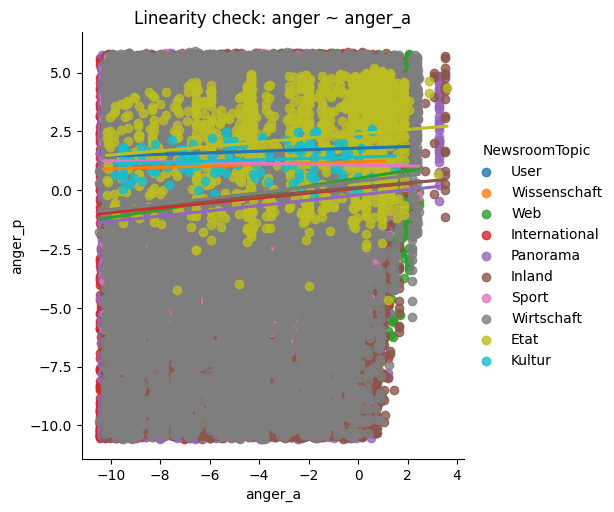

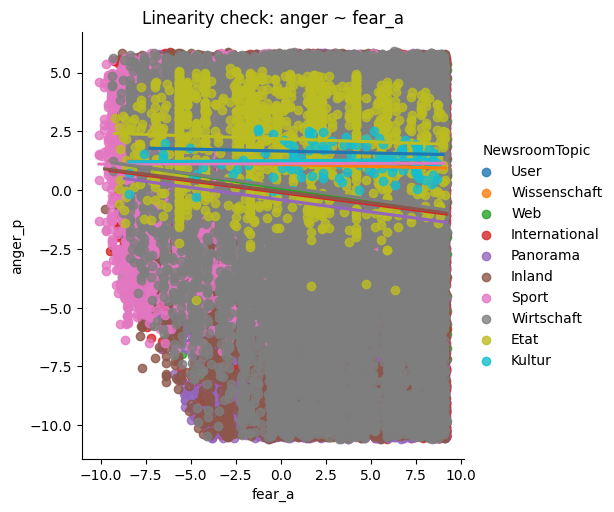

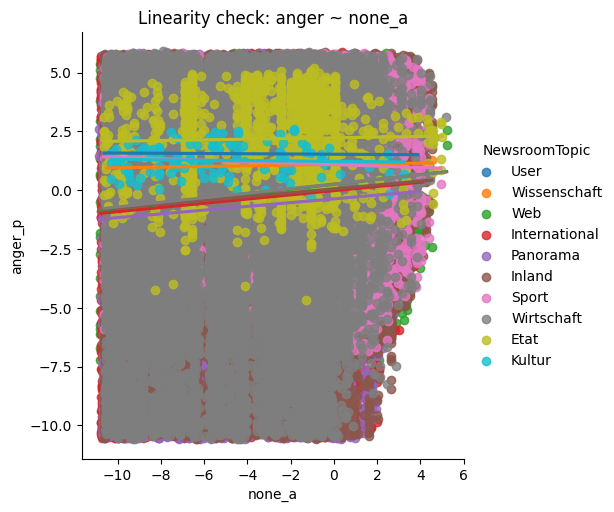

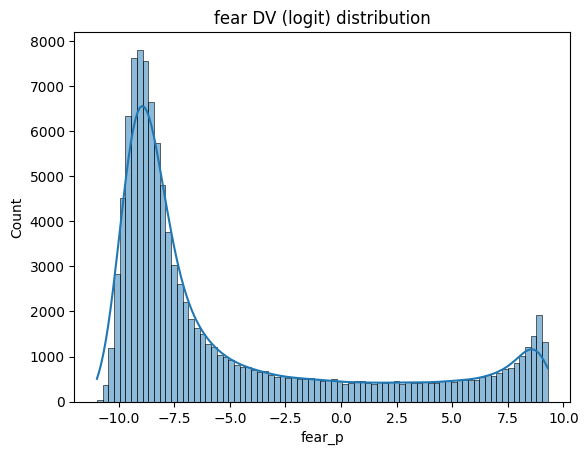

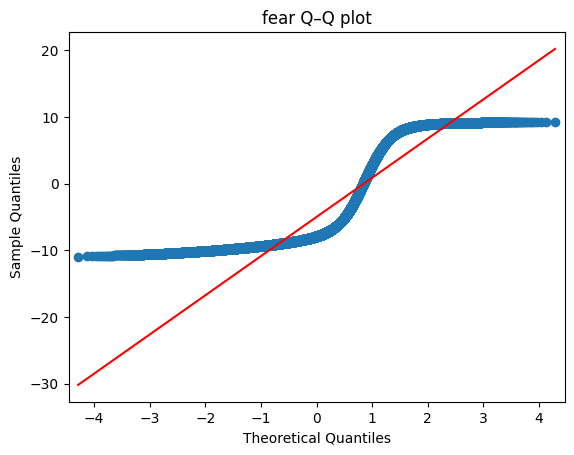

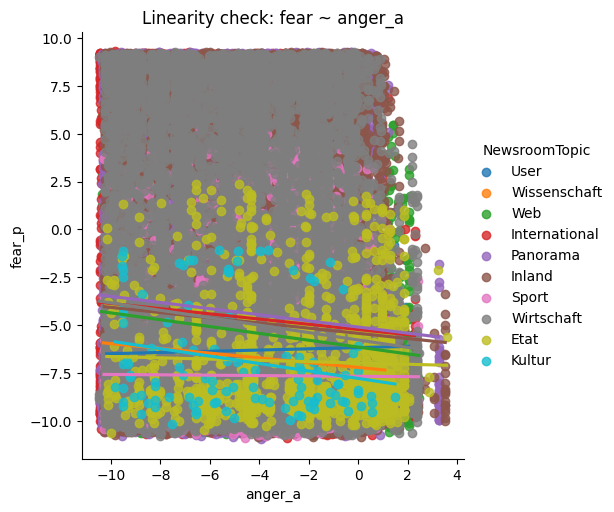

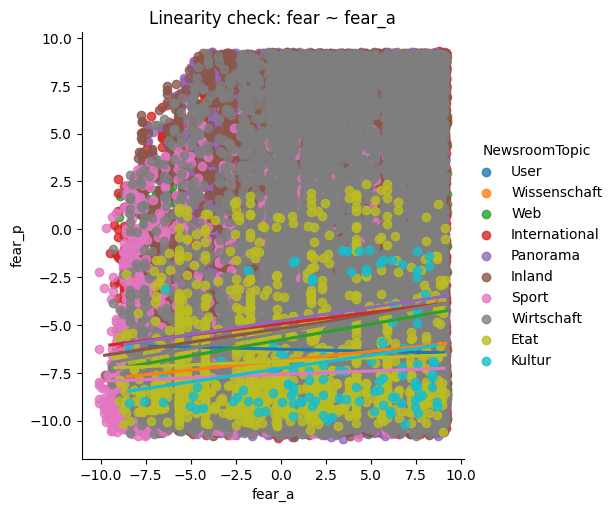

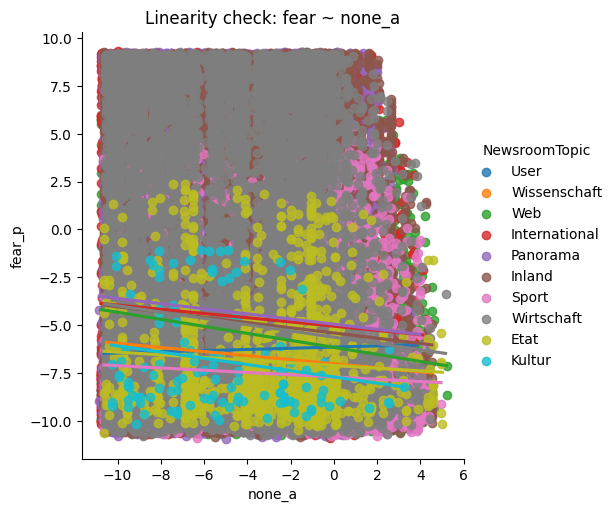

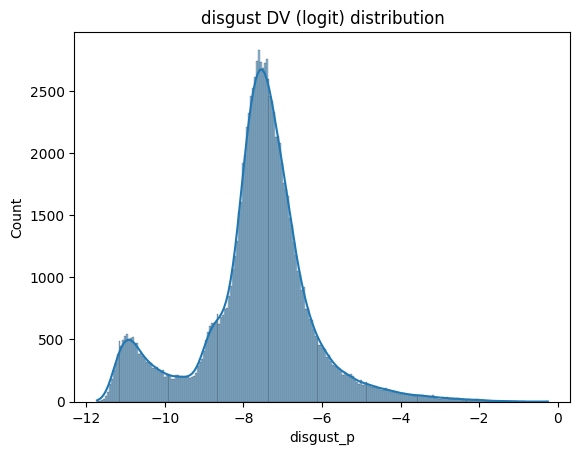

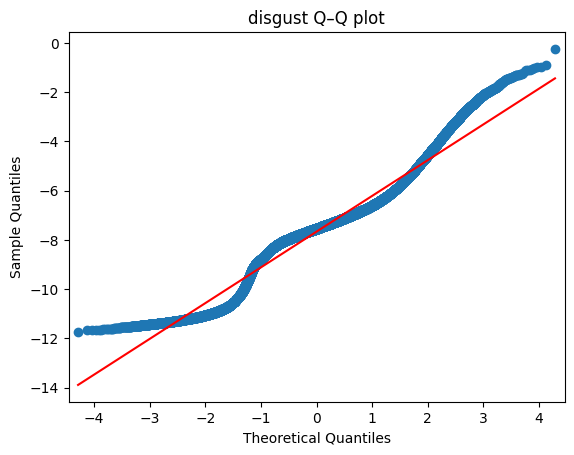

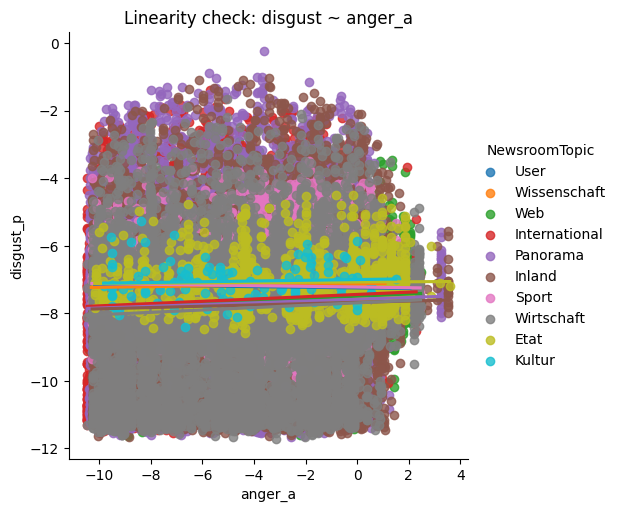

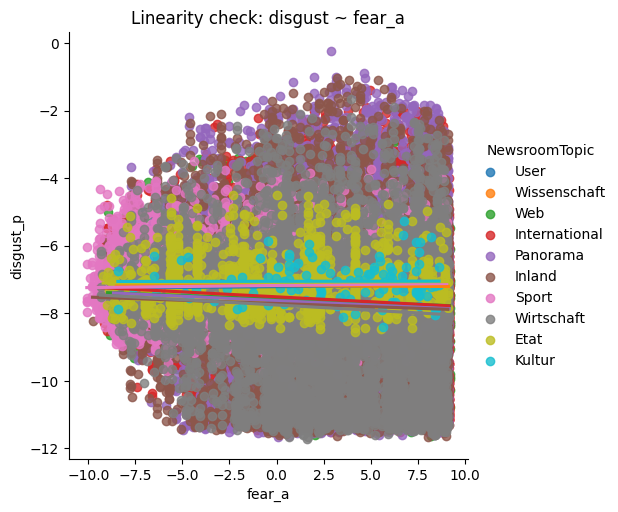

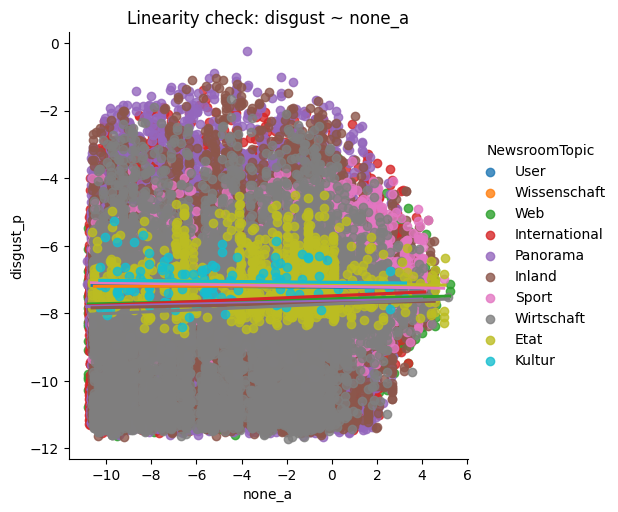

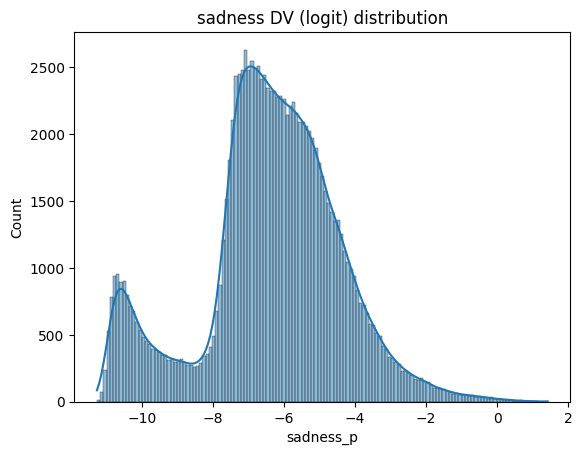

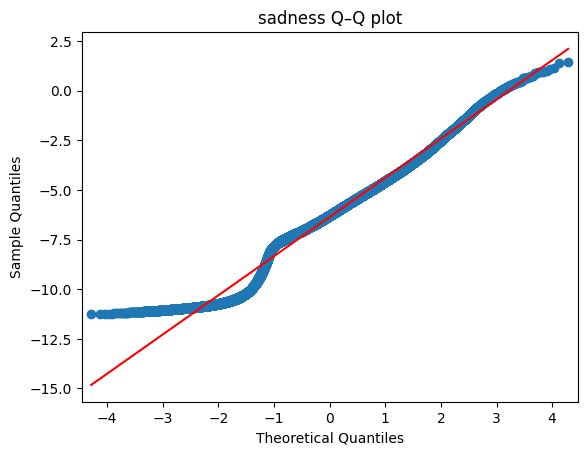

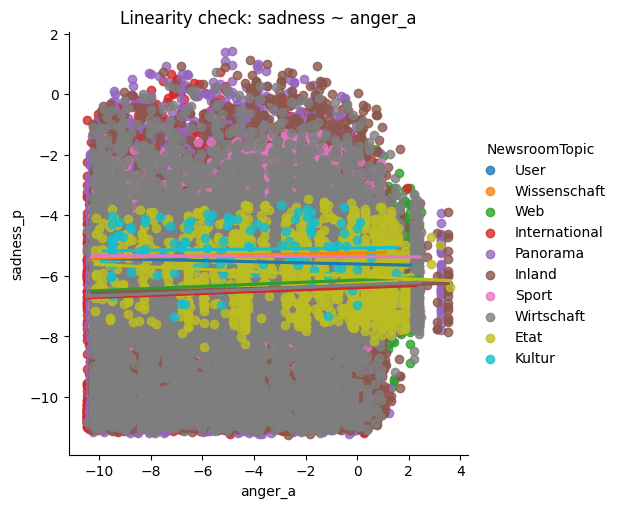

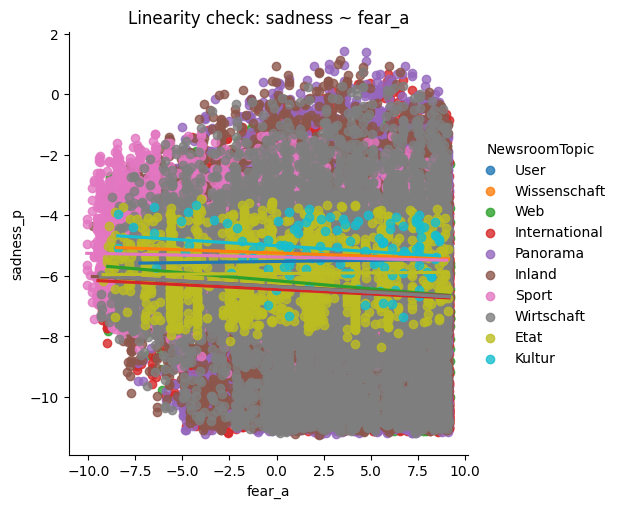

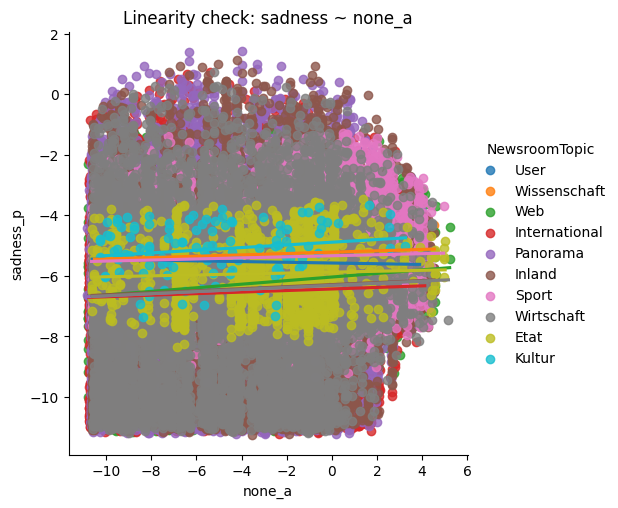

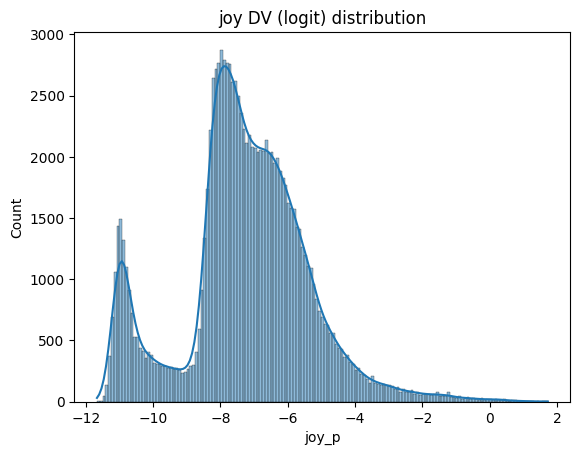

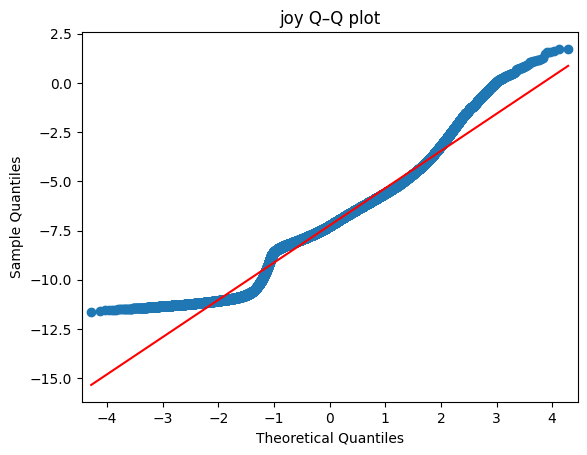

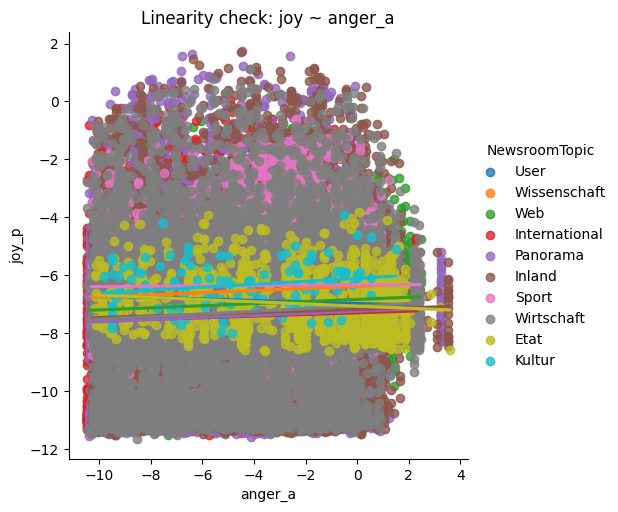

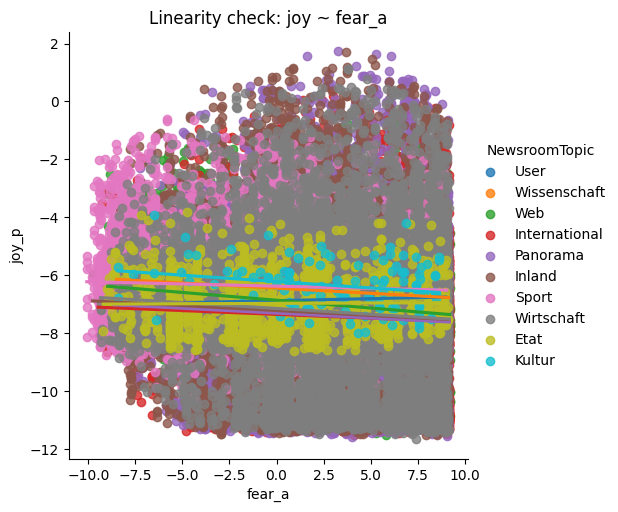

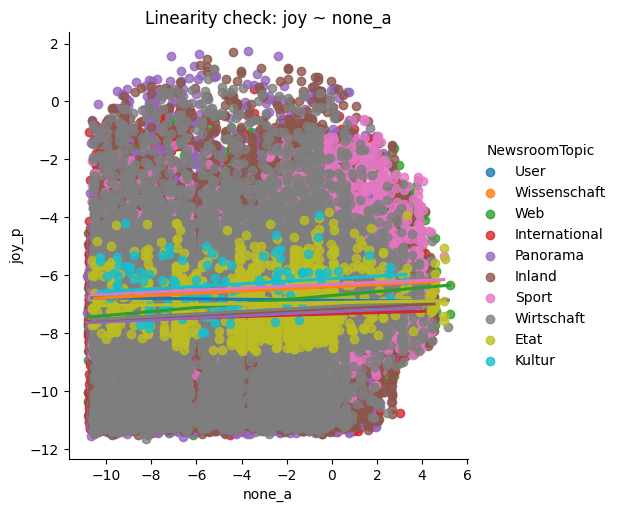

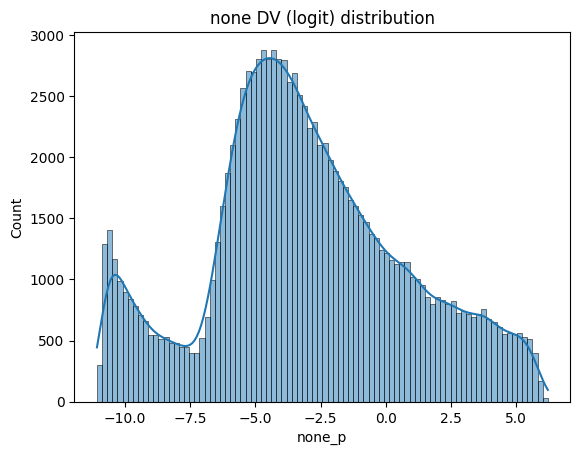

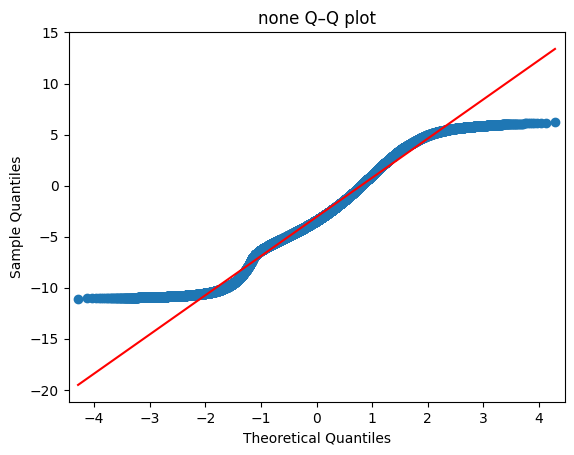

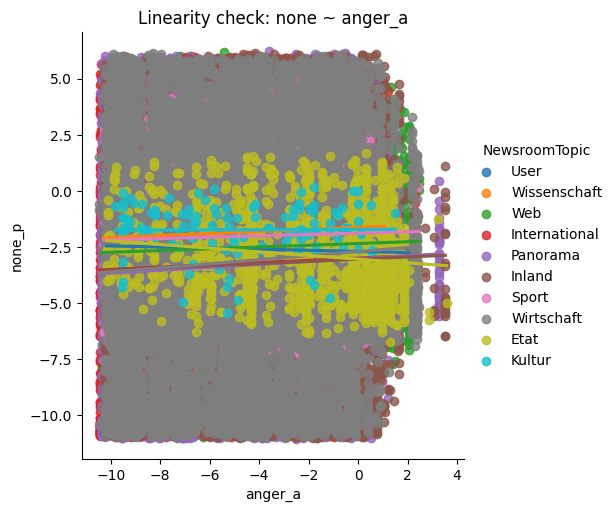

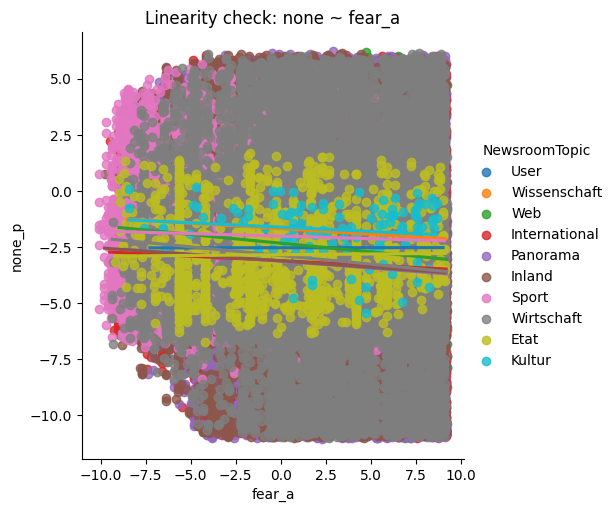

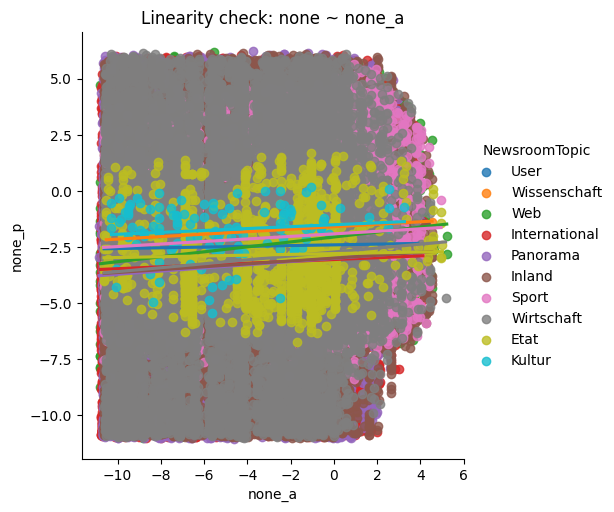

In [110]:
#plot distributions, qqplots, and regression lines for covariates on depedent variavles

for dv in emotions_p:
    sns.histplot(sentiments[f"{dv}_p"], kde=True)
    plt.title(f"{dv} DV (logit) distribution")
    plt.show()

    sm.qqplot(sentiments[f"{dv}_p"], line='s')
    plt.title(f"{dv} Q–Q plot")
    plt.show()

    for cov in emotions_a:
        sns.lmplot(
            x=f"{cov}_a",
            y=f"{dv}_p",
            hue="NewsroomTopic",
            data=sentiments,
            ci=None
        )
        plt.title(f"Linearity check: {dv} ~ {cov}_a")
        plt.show()

#large data size corrects for skewy data
#robust regression model might be nescessary

In [ ]:
#check assumption of homoscedacity of residuals

bp_results = {}

for dv in emotions_p:
    dep_var = f"{dv}_p"
    indep_vars = [f"{cov}_a" for cov in emotions_a]

    formula = dep_var + " ~ C(NewsroomTopic)"
    for var in indep_vars:
        formula += " + " + var

    model = ols(formula, data=sentiments).fit()
    residuals = model.resid
    exog = model.model.exog

    bp_test = het_breuschpagan(residuals, exog)
    p_bp = bp_test[1]
    bp_results[dv] = p_bp

for dv, p_bp in bp_results.items():
    print(f"{dv} BP p-value: {p_bp:.4f}")

#graphs look skewy and no homoscedacity of residuals
#->regressions with robust standard errors will be applied for further testings (HC3)
#outliers are filtered -> HC3
#if outliers were not filtered -> maybe rls?

anger BP p-value: 0.0000
fear BP p-value: 0.0000
disgust BP p-value: 0.0000
sadness BP p-value: 0.0000
joy BP p-value: 0.0000
none BP p-value: 0.0000


In [112]:
#check for interaction effects of independent variables

for e in emotions_a:
    formula = f"{e}_p ~ C(NewsroomTopic) * {e}_a"
    model = ols(formula, data=sentiments).fit()
    anova = sm.stats.anova_lm(model, typ=2)
    p_interaction = anova.loc[f"C(NewsroomTopic):{e}_a", "PR(>F)"]
    p_label = label_p(p_interaction)
    print(f"{e} interaction p-value: {p_interaction:.4f} ({p_label})")

#interactions between article and topic exist
#-> type III ANOVA

anger interaction p-value: 0.0000 (p <= .001)
fear interaction p-value: 0.0000 (p <= .001)
none interaction p-value: 0.0000 (p <= .001)


ANCOVAs

In [113]:
combined_results = []
for dv in emotions_p:

    #build formula with interactions
    interaction_terms = " + ".join([f"C(NewsroomTopic)*{cov}_a" for cov in emotions_a])
    formula = f"{dv}_p ~ {interaction_terms}"

    #fit robust regression model
    model = ols(formula, data=sentiments).fit(cov_type='HC3')

    #type III ANOVA
    anova_df = anova_lm(model, typ=3).reset_index()
    ss_error = anova_df.loc[anova_df['index'] == 'Residual', 'sum_sq'].values[0]

    #compute partial eta-squared
    anova_df['eta_p2'] = anova_df.apply(
        lambda row: row['sum_sq'] / (row['sum_sq'] + ss_error) if row['index'] != 'Residual' else np.nan,
        axis=1
    )

    #bonferroni correction for multiple testings
    corrected_pvals = multipletests(anova_df['PR(>F)'], method='bonferroni')[1]
    anova_df['p_bonf'] = corrected_pvals
    anova_df['p_label'] = anova_df['p_bonf'].apply(label_p)

    #topic-specific slopes for each covariate
    for cov in emotions_a:
        for topic in sentiments['NewsroomTopic'].unique():

            base_slope = model.params.get(f"{cov}_a", 0)
            interaction_term = f"C(NewsroomTopic)[T.{topic}]:{cov}_a"
            interaction_slope = model.params.get(interaction_term, 0)
            slope = base_slope + interaction_slope

            cov_row = anova_df[anova_df['index'].str.contains(f"{cov}_a")].iloc[0]

            combined_results.append({
                "emotion_p": dv,
                "type": "topic-specific",
                "NewsroomTopic": topic,
                "emotion_a": cov,
                "F": cov_row['F'],
                "p_uncorrected": cov_row['PR(>F)'],
                "p_bonf": cov_row['p_bonf'],
                "p_label": cov_row['p_label'],
                "eta_p2": cov_row['eta_p2'],
                "slope": slope
            })

    #add main effect of newsroomtopic
    topic_row = anova_df[anova_df['index'] == "C(NewsroomTopic)"].iloc[0]
    combined_results.append({
        "emotion_p": dv,
        "type": "main effect",
        "NewsroomTopic": "ALL",
        "emotion_a": "C(NewsroomTopic)",
        "F": topic_row['F'],
        "p_uncorrected": topic_row['PR(>F)'],
        "p_bonf": topic_row['p_bonf'],
        "p_label": topic_row['p_label'],
        "eta_p2": topic_row['eta_p2'],
        "slope": np.nan
    })

    #add overall interaction
    interaction_rows = anova_df[
            anova_df['index'].str.contains(":", regex=False) &
            anova_df['index'].str.contains("C(NewsroomTopic)", regex=False)
        ].copy()

    for _, row in interaction_rows.iterrows():
        combined_results.append({
            "emotion_p": dv,
            "type": "interaction",
            "NewsroomTopic": "ALL",
            "emotion_a": row['index'],
            "F": row['F'],
            "p_uncorrected": row['PR(>F)'],
            "p_bonf": row['p_bonf'],
            "p_label": row['p_label'],
            "eta_p2": row['eta_p2'],
            "slope": np.nan
        })

#combine results
results = pd.DataFrame(combined_results)
results.reset_index(drop=True, inplace=True)

Main Effects and Interactions

In [114]:
main_results = results[results['NewsroomTopic'] == 'ALL']
main_results

emotion_p         type NewsroomTopic                 emotion_a  \
30      anger  main effect           ALL          C(NewsroomTopic)   
31      anger  interaction           ALL  C(NewsroomTopic):anger_a   
32      anger  interaction           ALL   C(NewsroomTopic):fear_a   
33      anger  interaction           ALL   C(NewsroomTopic):none_a   
64       fear  main effect           ALL          C(NewsroomTopic)   
65       fear  interaction           ALL  C(NewsroomTopic):anger_a   
66       fear  interaction           ALL   C(NewsroomTopic):fear_a   
67       fear  interaction           ALL   C(NewsroomTopic):none_a   
98    disgust  main effect           ALL          C(NewsroomTopic)   
99    disgust  interaction           ALL  C(NewsroomTopic):anger_a   
100   disgust  interaction           ALL   C(NewsroomTopic):fear_a   
101   disgust  interaction           ALL   C(NewsroomTopic):none_a   
132   sadness  main effect           ALL          C(NewsroomTopic)   
133   sadness  interaction           ALL  C(NewsroomTopic):anger_a   
134   sadness  interaction           ALL   C(NewsroomTopic):fear_a   
135   sadness  interaction           ALL   C(NewsroomTopic):none_a   
166       joy  main effect           ALL          C(NewsroomTopic)   
167       joy  interaction           ALL  C(NewsroomTopic):anger_a   
168       joy  interaction           ALL   C(NewsroomTopic):fear_a   
169       joy  interaction           ALL   C(NewsroomTopic):none_a   
200      none  main effect           ALL          C(NewsroomTopic)   
201      none  interaction           ALL  C(NewsroomTopic):anger_a   
202      none  interaction           ALL   C(NewsroomTopic):fear_a   
203      none  interaction           ALL   C(NewsroomTopic):none_a   

              F  p_uncorrected     p_bonf    p_label     eta_p2  slope  
30  93.09417344     0.00000000 0.00000000  p <= .001 0.00751933    NaN  
31  10.37260621     0.00000000 0.00000000  p <= .001 0.00084344    NaN  
32  32.14113079     0.00000000 0.00000000  p <= .001 0.00260892    NaN  
33   8.19409381     0.00000000 0.00000000  p <= .001 0.00066642    NaN  
64  88.14823012     0.00000000 0.00000000  p <= .001 0.00712268    NaN  
65   2.13881215     0.02316295 0.20846653     p > .1 0.00017403    NaN  
66  24.05209666     0.00000000 0.00000000  p <= .001 0.00195361    NaN  
67   9.97158272     0.00000000 0.00000000  p <= .001 0.00081086    NaN  
98  77.11717780     0.00000000 0.00000000  p <= .001 0.00623690    NaN  
99   4.56396928     0.00000486 0.00004373  p <= .001 0.00037129    NaN  
100 34.43709111     0.00000000 0.00000000  p <= .001 0.00279477    NaN  
101 16.12947399     0.00000000 0.00000000  p <= .001 0.00131095    NaN  
132 77.54380436     0.00000000 0.00000000  p <= .001 0.00627118    NaN  
133  5.23590217     0.00000037 0.00000336  p <= .001 0.00042593    NaN  
134 13.04361873     0.00000000 0.00000000  p <= .001 0.00106041    NaN  
135  7.39677845     0.00000000 0.00000000  p <= .001 0.00060161    NaN  
166 55.42686041     0.00000000 0.00000000  p <= .001 0.00449056    NaN  
167  7.64393393     0.00000000 0.00000000  p <= .001 0.00062170    NaN  
168  8.57529616     0.00000000 0.00000000  p <= .001 0.00069740    NaN  
169 11.20373544     0.00000000 0.00000000  p <= .001 0.00091096    NaN  
200 30.38204848     0.00000000 0.00000000  p <= .001 0.00246649    NaN  
201  9.49456087     0.00000000 0.00000000  p <= .001 0.00077210    NaN  
202  5.21264877     0.00000041 0.00000368  p <= .001 0.00042404    NaN  
203  7.35958095     0.00000000 0.00000000  p <= .001 0.00059859    NaN

Topic Results

In [132]:
top_topic = (
    results.copy()
    .loc[results['p_bonf'] <= 0.05]
    .assign(abs_slope=lambda x: x['slope'].abs())
    .groupby('NewsroomTopic')
    .agg(
        mean_abs_slope=('abs_slope', 'mean'),
        max_abs_slope=('abs_slope', 'max'),
        count_significant=('eta_p2', 'count')
    )
    .sort_values('mean_abs_slope', ascending=False)
    .reset_index()
)
top_topic

NewsroomTopic  mean_abs_slope  max_abs_slope  count_significant
0            User      0.14851718     0.27989936                  6
1            Etat      0.11374522     0.20228303                  6
2             Web      0.07765629     0.14994074                  6
3    Wissenschaft      0.07325340     0.11620299                  6
4          Kultur      0.06824785     0.10349064                  6
5           Sport      0.03793861     0.08304295                  6
6          Inland      0.03565114     0.05640295                  6
7   International      0.03551587     0.07007414                  6
8        Panorama      0.03140071     0.06899150                  6
9      Wirtschaft      0.01750111     0.03730140                  6
10            ALL             NaN            NaN                 23

In [ ]:
top_slopes = (
    results
    .dropna(subset=['slope'])
    .loc[results['p_bonf'] <= 0.05]
    .assign(abs_slope=lambda x: x['slope'].abs())
    .sort_values('abs_slope', ascending=False)
    .head(20)
)
top_slopes

emotion_p            type NewsroomTopic emotion_a           F  \
170      none  topic-specific          User     anger 62.76620879   
178      none  topic-specific          Etat     anger 62.76620879   
102   sadness  topic-specific          User     anger 39.07213641   
8       anger  topic-specific          Etat     anger 50.76260791   
0       anger  topic-specific          User     anger 50.76260791   
136       joy  topic-specific          User     anger 45.02138655   
172      none  topic-specific           Web     anger 62.76620879   
171      none  topic-specific  Wissenschaft     anger 62.76620879   
165       joy  topic-specific        Kultur      none  8.48164056   
122   sadness  topic-specific          User      none 16.71286075   
179      none  topic-specific        Kultur     anger 62.76620879   
9       anger  topic-specific        Kultur     anger 50.76260791   
144       joy  topic-specific          Etat     anger 45.02138655   
110   sadness  topic-specific          Etat     anger 39.07213641   
111   sadness  topic-specific        Kultur     anger 39.07213641   
1       anger  topic-specific  Wissenschaft     anger 50.76260791   
162       joy  topic-specific         Sport      none  8.48164056   
2       anger  topic-specific           Web     anger 50.76260791   
104   sadness  topic-specific           Web     anger 39.07213641   
130   sadness  topic-specific          Etat      none 16.71286075   

     p_uncorrected     p_bonf    p_label     eta_p2       slope  abs_slope  
170     0.00000000 0.00000000  p <= .001 0.00056725 -0.27989936 0.27989936  
178     0.00000000 0.00000000  p <= .001 0.00056725 -0.20228303 0.20228303  
102     0.00000000 0.00000000  p <= .001 0.00035319 -0.18456353 0.18456353  
8       0.00000000 0.00000000  p <= .001 0.00045881  0.17221953 0.17221953  
0       0.00000000 0.00000000  p <= .001 0.00045881  0.16333307 0.16333307  
136     0.00000000 0.00000000  p <= .001 0.00040694 -0.15854792 0.15854792  
172     0.00000000 0.00000000  p <= .001 0.00056725 -0.14994074 0.14994074  
171     0.00000000 0.00000000  p <= .001 0.00056725 -0.11620299 0.11620299  
165     0.00358820 0.03229381   p <= .05 0.00007669 -0.10349064 0.10349064  
122     0.00004352 0.00039164  p <= .001 0.00015110 -0.10188199 0.10188199  
179     0.00000000 0.00000000  p <= .001 0.00056725 -0.09962459 0.09962459  
9       0.00000000 0.00000000  p <= .001 0.00045881  0.09802963 0.09802963  
144     0.00000000 0.00000000  p <= .001 0.00040694 -0.09256815 0.09256815  
110     0.00000000 0.00000000  p <= .001 0.00035319 -0.08735206 0.08735206  
111     0.00000000 0.00000000  p <= .001 0.00035319 -0.08449482 0.08449482  
1       0.00000000 0.00000000  p <= .001 0.00045881  0.08421550 0.08421550  
162     0.00358820 0.03229381   p <= .05 0.00007669  0.08304295 0.08304295  
2       0.00000000 0.00000000  p <= .001 0.00045881  0.08183714 0.08183714  
104     0.00000000 0.00000000  p <= .001 0.00035319 -0.07879486 0.07879486  
130     0.00004352 0.00039164  p <= .001 0.00015110  0.07851354 0.07851354

Results per Article Emotion

In [133]:
anger_a = results[results['emotion_a'] == 'anger']
anger_a

emotion_p            type  NewsroomTopic emotion_a           F  \
0       anger  topic-specific           User     anger 50.76260791   
1       anger  topic-specific   Wissenschaft     anger 50.76260791   
2       anger  topic-specific            Web     anger 50.76260791   
3       anger  topic-specific  International     anger 50.76260791   
4       anger  topic-specific       Panorama     anger 50.76260791   
5       anger  topic-specific         Inland     anger 50.76260791   
6       anger  topic-specific          Sport     anger 50.76260791   
7       anger  topic-specific     Wirtschaft     anger 50.76260791   
8       anger  topic-specific           Etat     anger 50.76260791   
9       anger  topic-specific         Kultur     anger 50.76260791   
34       fear  topic-specific           User     anger  0.04253756   
35       fear  topic-specific   Wissenschaft     anger  0.04253756   
36       fear  topic-specific            Web     anger  0.04253756   
37       fear  topic-specific  International     anger  0.04253756   
38       fear  topic-specific       Panorama     anger  0.04253756   
39       fear  topic-specific         Inland     anger  0.04253756   
40       fear  topic-specific          Sport     anger  0.04253756   
41       fear  topic-specific     Wirtschaft     anger  0.04253756   
42       fear  topic-specific           Etat     anger  0.04253756   
43       fear  topic-specific         Kultur     anger  0.04253756   
68    disgust  topic-specific           User     anger  2.48581146   
69    disgust  topic-specific   Wissenschaft     anger  2.48581146   
70    disgust  topic-specific            Web     anger  2.48581146   
71    disgust  topic-specific  International     anger  2.48581146   
72    disgust  topic-specific       Panorama     anger  2.48581146   
73    disgust  topic-specific         Inland     anger  2.48581146   
74    disgust  topic-specific          Sport     anger  2.48581146   
75    disgust  topic-specific     Wirtschaft     anger  2.48581146   
76    disgust  topic-specific           Etat     anger  2.48581146   
77    disgust  topic-specific         Kultur     anger  2.48581146   
102   sadness  topic-specific           User     anger 39.07213641   
103   sadness  topic-specific   Wissenschaft     anger 39.07213641   
104   sadness  topic-specific            Web     anger 39.07213641   
105   sadness  topic-specific  International     anger 39.07213641   
106   sadness  topic-specific       Panorama     anger 39.07213641   
107   sadness  topic-specific         Inland     anger 39.07213641   
108   sadness  topic-specific          Sport     anger 39.07213641   
109   sadness  topic-specific     Wirtschaft     anger 39.07213641   
110   sadness  topic-specific           Etat     anger 39.07213641   
111   sadness  topic-specific         Kultur     anger 39.07213641   
136       joy  topic-specific           User     anger 45.02138655   
137       joy  topic-specific   Wissenschaft     anger 45.02138655   
138       joy  topic-specific            Web     anger 45.02138655   
139       joy  topic-specific  International     anger 45.02138655   
140       joy  topic-specific       Panorama     anger 45.02138655   
141       joy  topic-specific         Inland     anger 45.02138655   
142       joy  topic-specific          Sport     anger 45.02138655   
143       joy  topic-specific     Wirtschaft     anger 45.02138655   
144       joy  topic-specific           Etat     anger 45.02138655   
145       joy  topic-specific         Kultur     anger 45.02138655   
170      none  topic-specific           User     anger 62.76620879   
171      none  topic-specific   Wissenschaft     anger 62.76620879   
172      none  topic-specific            Web     anger 62.76620879   
173      none  topic-specific  International     anger 62.76620879   
174      none  topic-specific       Panorama     anger 62.76620879   
175      none  topic-specific         Inland     anger 62.76620879   
176      none 

In [134]:
fear_a = results[results['emotion_a'] == 'fear']
fear_a

emotion_p            type  NewsroomTopic emotion_a          F  \
10      anger  topic-specific           User      fear 2.52160495   
11      anger  topic-specific   Wissenschaft      fear 2.52160495   
12      anger  topic-specific            Web      fear 2.52160495   
13      anger  topic-specific  International      fear 2.52160495   
14      anger  topic-specific       Panorama      fear 2.52160495   
15      anger  topic-specific         Inland      fear 2.52160495   
16      anger  topic-specific          Sport      fear 2.52160495   
17      anger  topic-specific     Wirtschaft      fear 2.52160495   
18      anger  topic-specific           Etat      fear 2.52160495   
19      anger  topic-specific         Kultur      fear 2.52160495   
44       fear  topic-specific           User      fear 0.52156661   
45       fear  topic-specific   Wissenschaft      fear 0.52156661   
46       fear  topic-specific            Web      fear 0.52156661   
47       fear  topic-specific  International      fear 0.52156661   
48       fear  topic-specific       Panorama      fear 0.52156661   
49       fear  topic-specific         Inland      fear 0.52156661   
50       fear  topic-specific          Sport      fear 0.52156661   
51       fear  topic-specific     Wirtschaft      fear 0.52156661   
52       fear  topic-specific           Etat      fear 0.52156661   
53       fear  topic-specific         Kultur      fear 0.52156661   
78    disgust  topic-specific           User      fear 0.51299626   
79    disgust  topic-specific   Wissenschaft      fear 0.51299626   
80    disgust  topic-specific            Web      fear 0.51299626   
81    disgust  topic-specific  International      fear 0.51299626   
82    disgust  topic-specific       Panorama      fear 0.51299626   
83    disgust  topic-specific         Inland      fear 0.51299626   
84    disgust  topic-specific          Sport      fear 0.51299626   
85    disgust  topic-specific     Wirtschaft      fear 0.51299626   
86    disgust  topic-specific           Etat      fear 0.51299626   
87    disgust  topic-specific         Kultur      fear 0.51299626   
112   sadness  topic-specific           User      fear 0.05246602   
113   sadness  topic-specific   Wissenschaft      fear 0.05246602   
114   sadness  topic-specific            Web      fear 0.05246602   
115   sadness  topic-specific  International      fear 0.05246602   
116   sadness  topic-specific       Panorama      fear 0.05246602   
117   sadness  topic-specific         Inland      fear 0.05246602   
118   sadness  topic-specific          Sport      fear 0.05246602   
119   sadness  topic-specific     Wirtschaft      fear 0.05246602   
120   sadness  topic-specific           Etat      fear 0.05246602   
121   sadness  topic-specific         Kultur      fear 0.05246602   
146       joy  topic-specific           User      fear 1.49384519   
147       joy  topic-specific   Wissenschaft      fear 1.49384519   
148       joy  topic-specific            Web      fear 1.49384519   
149       joy  topic-specific  International      fear 1.49384519   
150       joy  topic-specific       Panorama      fear 1.49384519   
151       joy  topic-specific         Inland      fear 1.49384519   
152       joy  topic-specific          Sport      fear 1.49384519   
153       joy  topic-specific     Wirtschaft      fear 1.49384519   
154       joy  topic-specific           Etat      fear 1.49384519   
155       joy  topic-specific         Kultur      fear 1.49384519   
180      none  topic-specific           User      fear 3.78037489   
181      none  topic-specific   Wissenschaft      fear 3.78037489   
182      none  topic-specific            Web      fear 3.78037489   
183      none  topic-specific  International      fear 3.78037489   
184      none  topic-specific       Panorama      fear 3.78037489   
185      none  topic-specific         Inland      fear 3.78037489   
186      none  topic-specific          Sport      fear 3.78037489   
18

In [135]:
none_a = results[results['emotion_a'] == 'none']
none_a

emotion_p            type  NewsroomTopic emotion_a           F  \
20      anger  topic-specific           User      none  1.80451746   
21      anger  topic-specific   Wissenschaft      none  1.80451746   
22      anger  topic-specific            Web      none  1.80451746   
23      anger  topic-specific  International      none  1.80451746   
24      anger  topic-specific       Panorama      none  1.80451746   
25      anger  topic-specific         Inland      none  1.80451746   
26      anger  topic-specific          Sport      none  1.80451746   
27      anger  topic-specific     Wirtschaft      none  1.80451746   
28      anger  topic-specific           Etat      none  1.80451746   
29      anger  topic-specific         Kultur      none  1.80451746   
54       fear  topic-specific           User      none  4.49348358   
55       fear  topic-specific   Wissenschaft      none  4.49348358   
56       fear  topic-specific            Web      none  4.49348358   
57       fear  topic-specific  International      none  4.49348358   
58       fear  topic-specific       Panorama      none  4.49348358   
59       fear  topic-specific         Inland      none  4.49348358   
60       fear  topic-specific          Sport      none  4.49348358   
61       fear  topic-specific     Wirtschaft      none  4.49348358   
62       fear  topic-specific           Etat      none  4.49348358   
63       fear  topic-specific         Kultur      none  4.49348358   
88    disgust  topic-specific           User      none  5.52118488   
89    disgust  topic-specific   Wissenschaft      none  5.52118488   
90    disgust  topic-specific            Web      none  5.52118488   
91    disgust  topic-specific  International      none  5.52118488   
92    disgust  topic-specific       Panorama      none  5.52118488   
93    disgust  topic-specific         Inland      none  5.52118488   
94    disgust  topic-specific          Sport      none  5.52118488   
95    disgust  topic-specific     Wirtschaft      none  5.52118488   
96    disgust  topic-specific           Etat      none  5.52118488   
97    disgust  topic-specific         Kultur      none  5.52118488   
122   sadness  topic-specific           User      none 16.71286075   
123   sadness  topic-specific   Wissenschaft      none 16.71286075   
124   sadness  topic-specific            Web      none 16.71286075   
125   sadness  topic-specific  International      none 16.71286075   
126   sadness  topic-specific       Panorama      none 16.71286075   
127   sadness  topic-specific         Inland      none 16.71286075   
128   sadness  topic-specific          Sport      none 16.71286075   
129   sadness  topic-specific     Wirtschaft      none 16.71286075   
130   sadness  topic-specific           Etat      none 16.71286075   
131   sadness  topic-specific         Kultur      none 16.71286075   
156       joy  topic-specific           User      none  8.48164056   
157       joy  topic-specific   Wissenschaft      none  8.48164056   
158       joy  topic-specific            Web      none  8.48164056   
159       joy  topic-specific  International      none  8.48164056   
160       joy  topic-specific       Panorama      none  8.48164056   
161       joy  topic-specific         Inland      none  8.48164056   
162       joy  topic-specific          Sport      none  8.48164056   
163       joy  topic-specific     Wirtschaft      none  8.48164056   
164       joy  topic-specific           Etat      none  8.48164056   
165       joy  topic-specific         Kultur      none  8.48164056   
190      none  topic-specific           User      none  5.23183303   
191      none  topic-specific   Wissenschaft      none  5.23183303   
192      none  topic-specific            Web      none  5.23183303   
193      none  topic-specific  International      none  5.23183303   
194      none  topic-specific       Panorama      none  5.23183303   
195      none  topic-specific         Inland      none  5.23183303   
196      none 

Results per Post emotion

In [136]:
anger_p = results[results['emotion_p'] == 'anger']
anger_p

emotion_p            type  NewsroomTopic                 emotion_a  \
0      anger  topic-specific           User                     anger   
1      anger  topic-specific   Wissenschaft                     anger   
2      anger  topic-specific            Web                     anger   
3      anger  topic-specific  International                     anger   
4      anger  topic-specific       Panorama                     anger   
5      anger  topic-specific         Inland                     anger   
6      anger  topic-specific          Sport                     anger   
7      anger  topic-specific     Wirtschaft                     anger   
8      anger  topic-specific           Etat                     anger   
9      anger  topic-specific         Kultur                     anger   
10     anger  topic-specific           User                      fear   
11     anger  topic-specific   Wissenschaft                      fear   
12     anger  topic-specific            Web                      fear   
13     anger  topic-specific  International                      fear   
14     anger  topic-specific       Panorama                      fear   
15     anger  topic-specific         Inland                      fear   
16     anger  topic-specific          Sport                      fear   
17     anger  topic-specific     Wirtschaft                      fear   
18     anger  topic-specific           Etat                      fear   
19     anger  topic-specific         Kultur                      fear   
20     anger  topic-specific           User                      none   
21     anger  topic-specific   Wissenschaft                      none   
22     anger  topic-specific            Web                      none   
23     anger  topic-specific  International                      none   
24     anger  topic-specific       Panorama                      none   
25     anger  topic-specific         Inland                      none   
26     anger  topic-specific          Sport                      none   
27     anger  topic-specific     Wirtschaft                      none   
28     anger  topic-specific           Etat                      none   
29     anger  topic-specific         Kultur                      none   
30     anger     main effect            ALL          C(NewsroomTopic)   
31     anger     interaction            ALL  C(NewsroomTopic):anger_a   
32     anger     interaction            ALL   C(NewsroomTopic):fear_a   
33     anger     interaction            ALL   C(NewsroomTopic):none_a   

             F  p_uncorrected     p_bonf    p_label     eta_p2       slope  
0  50.76260791     0.00000000 0.00000000  p <= .001 0.00045881  0.16333307  
1  50.76260791     0.00000000 0.00000000  p <= .001 0.00045881  0.08421550  
2  50.76260791     0.00000000 0.00000000  p <= .001 0.00045881  0.08183714  
3  50.76260791     0.00000000 0.00000000  p <= .001 0.00045881 -0.05940008  
4  50.76260791     0.00000000 0.00000000  p <= .001 0.00045881 -0.01076264  
5  50.76260791     0.00000000 0.00000000  p <= .001 0.00045881 -0.04396863  
6  50.76260791     0.00000000 0.00000000  p <= .001 0.00045881  0.01502249  
7  50.76260791     0.00000000 0.00000000  p <= .001 0.00045881 -0.00529746  
8  50.76260791     0.00000000 0.00000000  p <= .001 0.00045881  0.17221953  
9  50.76260791     0.00000000 0.00000000  p <= .001 0.00045881  0.09802963  
10  2.52160495     0.11229910 1.00000000     p > .1 0.00002280  0.04007228  
11  2.52160495     0.11229910 1.00000000     p > .1 0.00002280 -0.00933488  
12  2.52160495     0.11229910 1.00000000     p > .1 0.00002280 -0.27134605  
13  2.52160495     0.11229910 1.00000000     p > .1 0.00002280 -0.26994175  
14  2.52160495     0.11229910 1.00000000     p > .1 0.00002280 -0.38949818  
15  2.52160495     0.11229910 1.00000000     p > .1 0.00002280 -0.32343985  
16  2.52160495     0.11229910 1.00000000     p > .1 0.00002280 -0.08291687  
17  2.52160495     0.11229910 1.00000000     p > .1 0.0000228

In [137]:
fear_p = results[results['emotion_p'] == 'fear']
fear_p

emotion_p            type  NewsroomTopic                 emotion_a  \
34      fear  topic-specific           User                     anger   
35      fear  topic-specific   Wissenschaft                     anger   
36      fear  topic-specific            Web                     anger   
37      fear  topic-specific  International                     anger   
38      fear  topic-specific       Panorama                     anger   
39      fear  topic-specific         Inland                     anger   
40      fear  topic-specific          Sport                     anger   
41      fear  topic-specific     Wirtschaft                     anger   
42      fear  topic-specific           Etat                     anger   
43      fear  topic-specific         Kultur                     anger   
44      fear  topic-specific           User                      fear   
45      fear  topic-specific   Wissenschaft                      fear   
46      fear  topic-specific            Web                      fear   
47      fear  topic-specific  International                      fear   
48      fear  topic-specific       Panorama                      fear   
49      fear  topic-specific         Inland                      fear   
50      fear  topic-specific          Sport                      fear   
51      fear  topic-specific     Wirtschaft                      fear   
52      fear  topic-specific           Etat                      fear   
53      fear  topic-specific         Kultur                      fear   
54      fear  topic-specific           User                      none   
55      fear  topic-specific   Wissenschaft                      none   
56      fear  topic-specific            Web                      none   
57      fear  topic-specific  International                      none   
58      fear  topic-specific       Panorama                      none   
59      fear  topic-specific         Inland                      none   
60      fear  topic-specific          Sport                      none   
61      fear  topic-specific     Wirtschaft                      none   
62      fear  topic-specific           Etat                      none   
63      fear  topic-specific         Kultur                      none   
64      fear     main effect            ALL          C(NewsroomTopic)   
65      fear     interaction            ALL  C(NewsroomTopic):anger_a   
66      fear     interaction            ALL   C(NewsroomTopic):fear_a   
67      fear     interaction            ALL   C(NewsroomTopic):none_a   

             F  p_uncorrected     p_bonf    p_label     eta_p2       slope  
34  0.04253756     0.83659886 1.00000000     p > .1 0.00000038  0.20056372  
35  0.04253756     0.83659886 1.00000000     p > .1 0.00000038 -0.04284753  
36  0.04253756     0.83659886 1.00000000     p > .1 0.00000038  0.04385688  
37  0.04253756     0.83659886 1.00000000     p > .1 0.00000038  0.00153892  
38  0.04253756     0.83659886 1.00000000     p > .1 0.00000038  0.01941292  
39  0.04253756     0.83659886 1.00000000     p > .1 0.00000038  0.08043052  
40  0.04253756     0.83659886 1.00000000     p > .1 0.00000038  0.07546989  
41  0.04253756     0.83659886 1.00000000     p > .1 0.00000038 -0.01477005  
42  0.04253756     0.83659886 1.00000000     p > .1 0.00000038  0.00787547  
43  0.04253756     0.83659886 1.00000000     p > .1 0.00000038 -0.13922467  
44  0.52156661     0.47017570 1.00000000     p > .1 0.00000472  0.28726116  
45  0.52156661     0.47017570 1.00000000     p > .1 0.00000472 -0.09259976  
46  0.52156661     0.47017570 1.00000000     p > .1 0.00000472  0.20840100  
47  0.52156661     0.47017570 1.00000000     p > .1 0.00000472  0.24961012  
48  0.52156661     0.47017570 1.00000000     p > .1 0.00000472  0.30330332  
49  0.52156661     0.47017570 1.00000000     p > .1 0.00000472  0.35156920  
50  0.52156661     0.47017570 1.00000000     p > .1 0.00000472  0.00587946  
51  0.52156661     0.47017570 1.00000000     p > .1 0.0000047

In [138]:
disgust_p = results[results['emotion_p'] == 'disgust']
disgust_p

emotion_p            type  NewsroomTopic                 emotion_a  \
68    disgust  topic-specific           User                     anger   
69    disgust  topic-specific   Wissenschaft                     anger   
70    disgust  topic-specific            Web                     anger   
71    disgust  topic-specific  International                     anger   
72    disgust  topic-specific       Panorama                     anger   
73    disgust  topic-specific         Inland                     anger   
74    disgust  topic-specific          Sport                     anger   
75    disgust  topic-specific     Wirtschaft                     anger   
76    disgust  topic-specific           Etat                     anger   
77    disgust  topic-specific         Kultur                     anger   
78    disgust  topic-specific           User                      fear   
79    disgust  topic-specific   Wissenschaft                      fear   
80    disgust  topic-specific            Web                      fear   
81    disgust  topic-specific  International                      fear   
82    disgust  topic-specific       Panorama                      fear   
83    disgust  topic-specific         Inland                      fear   
84    disgust  topic-specific          Sport                      fear   
85    disgust  topic-specific     Wirtschaft                      fear   
86    disgust  topic-specific           Etat                      fear   
87    disgust  topic-specific         Kultur                      fear   
88    disgust  topic-specific           User                      none   
89    disgust  topic-specific   Wissenschaft                      none   
90    disgust  topic-specific            Web                      none   
91    disgust  topic-specific  International                      none   
92    disgust  topic-specific       Panorama                      none   
93    disgust  topic-specific         Inland                      none   
94    disgust  topic-specific          Sport                      none   
95    disgust  topic-specific     Wirtschaft                      none   
96    disgust  topic-specific           Etat                      none   
97    disgust  topic-specific         Kultur                      none   
98    disgust     main effect            ALL          C(NewsroomTopic)   
99    disgust     interaction            ALL  C(NewsroomTopic):anger_a   
100   disgust     interaction            ALL   C(NewsroomTopic):fear_a   
101   disgust     interaction            ALL   C(NewsroomTopic):none_a   

              F  p_uncorrected     p_bonf    p_label     eta_p2       slope  
68   2.48581146     0.11487995 1.00000000     p > .1 0.00002248 -0.07516373  
69   2.48581146     0.11487995 1.00000000     p > .1 0.00002248  0.06110311  
70   2.48581146     0.11487995 1.00000000     p > .1 0.00002248  0.02303525  
71   2.48581146     0.11487995 1.00000000     p > .1 0.00002248 -0.00218418  
72   2.48581146     0.11487995 1.00000000     p > .1 0.00002248 -0.00516228  
73   2.48581146     0.11487995 1.00000000     p > .1 0.00002248 -0.00397969  
74   2.48581146     0.11487995 1.00000000     p > .1 0.00002248 -0.00028713  
75   2.48581146     0.11487995 1.00000000     p > .1 0.00002248 -0.00078110  
76   2.48581146     0.11487995 1.00000000     p > .1 0.00002248  0.01539456  
77   2.48581146     0.11487995 1.00000000     p > .1 0.00002248  0.03723707  
78   0.51299626     0.47384618 1.00000000     p > .1 0.00000464 -0.09485587  
79   0.51299626     0.47384618 1.00000000     p > .1 0.00000464 -0.01778394  
80   0.51299626     0.47384618 1.00000000     p > .1 0.00000464 -0.07428883  
81   0.51299626     0.47384618 1.00000000     p > .1 0.00000464 -0.05992110  
82   0.51299626     0.47384618 1.00000000     p > .1 0.00000464 -0.14743379  
83   0.51299626     0.47384618 1.00000000     p > .1 0.00000464 -0.08325217  
84   0.51299626     0.47384618 1.00000000     p > .1 0.00000464 -0.00045076  
85   0.51

In [139]:
sadness_p = results[results['emotion_p'] == 'sadness']
sadness_p

emotion_p            type  NewsroomTopic                 emotion_a  \
102   sadness  topic-specific           User                     anger   
103   sadness  topic-specific   Wissenschaft                     anger   
104   sadness  topic-specific            Web                     anger   
105   sadness  topic-specific  International                     anger   
106   sadness  topic-specific       Panorama                     anger   
107   sadness  topic-specific         Inland                     anger   
108   sadness  topic-specific          Sport                     anger   
109   sadness  topic-specific     Wirtschaft                     anger   
110   sadness  topic-specific           Etat                     anger   
111   sadness  topic-specific         Kultur                     anger   
112   sadness  topic-specific           User                      fear   
113   sadness  topic-specific   Wissenschaft                      fear   
114   sadness  topic-specific            Web                      fear   
115   sadness  topic-specific  International                      fear   
116   sadness  topic-specific       Panorama                      fear   
117   sadness  topic-specific         Inland                      fear   
118   sadness  topic-specific          Sport                      fear   
119   sadness  topic-specific     Wirtschaft                      fear   
120   sadness  topic-specific           Etat                      fear   
121   sadness  topic-specific         Kultur                      fear   
122   sadness  topic-specific           User                      none   
123   sadness  topic-specific   Wissenschaft                      none   
124   sadness  topic-specific            Web                      none   
125   sadness  topic-specific  International                      none   
126   sadness  topic-specific       Panorama                      none   
127   sadness  topic-specific         Inland                      none   
128   sadness  topic-specific          Sport                      none   
129   sadness  topic-specific     Wirtschaft                      none   
130   sadness  topic-specific           Etat                      none   
131   sadness  topic-specific         Kultur                      none   
132   sadness     main effect            ALL          C(NewsroomTopic)   
133   sadness     interaction            ALL  C(NewsroomTopic):anger_a   
134   sadness     interaction            ALL   C(NewsroomTopic):fear_a   
135   sadness     interaction            ALL   C(NewsroomTopic):none_a   

              F  p_uncorrected     p_bonf    p_label     eta_p2       slope  
102 39.07213641     0.00000000 0.00000000  p <= .001 0.00035319 -0.18456353  
103 39.07213641     0.00000000 0.00000000  p <= .001 0.00035319 -0.07295030  
104 39.07213641     0.00000000 0.00000000  p <= .001 0.00035319 -0.07879486  
105 39.07213641     0.00000000 0.00000000  p <= .001 0.00035319 -0.01465116  
106 39.07213641     0.00000000 0.00000000  p <= .001 0.00035319 -0.05049577  
107 39.07213641     0.00000000 0.00000000  p <= .001 0.00035319 -0.05096155  
108 39.07213641     0.00000000 0.00000000  p <= .001 0.00035319 -0.03299982  
109 39.07213641     0.00000000 0.00000000  p <= .001 0.00035319 -0.03325842  
110 39.07213641     0.00000000 0.00000000  p <= .001 0.00035319 -0.08735206  
111 39.07213641     0.00000000 0.00000000  p <= .001 0.00035319 -0.08449482  
112  0.05246602     0.81882688 1.00000000     p > .1 0.00000047 -0.25448225  
113  0.05246602     0.81882688 1.00000000     p > .1 0.00000047 -0.03031915  
114  0.05246602     0.81882688 1.00000000     p > .1 0.00000047 -0.09834990  
115  0.05246602     0.81882688 1.00000000     p > .1 0.00000047 -0.10081639  
116  0.05246602     0.81882688 1.00000000     p > .1 0.00000047 -0.10091833  
117  0.05246602     0.81882688 1.00000000     p > .1 0.00000047 -0.08407793  
118  0.05246602     0.81882688 1.00000000     p > .1 0.00000047 -0.00931983  
119  0.05

In [140]:
joy_p = results[results['emotion_p'] == 'joy']
joy_p

emotion_p            type  NewsroomTopic                 emotion_a  \
136       joy  topic-specific           User                     anger   
137       joy  topic-specific   Wissenschaft                     anger   
138       joy  topic-specific            Web                     anger   
139       joy  topic-specific  International                     anger   
140       joy  topic-specific       Panorama                     anger   
141       joy  topic-specific         Inland                     anger   
142       joy  topic-specific          Sport                     anger   
143       joy  topic-specific     Wirtschaft                     anger   
144       joy  topic-specific           Etat                     anger   
145       joy  topic-specific         Kultur                     anger   
146       joy  topic-specific           User                      fear   
147       joy  topic-specific   Wissenschaft                      fear   
148       joy  topic-specific            Web                      fear   
149       joy  topic-specific  International                      fear   
150       joy  topic-specific       Panorama                      fear   
151       joy  topic-specific         Inland                      fear   
152       joy  topic-specific          Sport                      fear   
153       joy  topic-specific     Wirtschaft                      fear   
154       joy  topic-specific           Etat                      fear   
155       joy  topic-specific         Kultur                      fear   
156       joy  topic-specific           User                      none   
157       joy  topic-specific   Wissenschaft                      none   
158       joy  topic-specific            Web                      none   
159       joy  topic-specific  International                      none   
160       joy  topic-specific       Panorama                      none   
161       joy  topic-specific         Inland                      none   
162       joy  topic-specific          Sport                      none   
163       joy  topic-specific     Wirtschaft                      none   
164       joy  topic-specific           Etat                      none   
165       joy  topic-specific         Kultur                      none   
166       joy     main effect            ALL          C(NewsroomTopic)   
167       joy     interaction            ALL  C(NewsroomTopic):anger_a   
168       joy     interaction            ALL   C(NewsroomTopic):fear_a   
169       joy     interaction            ALL   C(NewsroomTopic):none_a   

              F  p_uncorrected     p_bonf    p_label     eta_p2       slope  
136 45.02138655     0.00000000 0.00000000  p <= .001 0.00040694 -0.15854792  
137 45.02138655     0.00000000 0.00000000  p <= .001 0.00040694 -0.05598747  
138 45.02138655     0.00000000 0.00000000  p <= .001 0.00040694 -0.07627403  
139 45.02138655     0.00000000 0.00000000  p <= .001 0.00040694 -0.00627918  
140 45.02138655     0.00000000 0.00000000  p <= .001 0.00040694 -0.02161393  
141 45.02138655     0.00000000 0.00000000  p <= .001 0.00040694 -0.03561082  
142 45.02138655     0.00000000 0.00000000  p <= .001 0.00040694 -0.04207193  
143 45.02138655     0.00000000 0.00000000  p <= .001 0.00040694 -0.01441224  
144 45.02138655     0.00000000 0.00000000  p <= .001 0.00040694 -0.09256815  
145 45.02138655     0.00000000 0.00000000  p <= .001 0.00040694  0.02303452  
146  1.49384519     0.22162342 1.00000000     p > .1 0.00001351 -0.14310293  
147  1.49384519     0.22162342 1.00000000     p > .1 0.00001351 -0.01518424  
148  1.49384519     0.22162342 1.00000000     p > .1 0.00001351 -0.03498969  
149  1.49384519     0.22162342 1.00000000     p > .1 0.00001351 -0.07539343  
150  1.49384519     0.22162342 1.00000000     p > .1 0.00001351 -0.05208320  
151  1.49384519     0.22162342 1.00000000     p > .1 0.00001351 -0.05785452  
152  1.49384519     0.22162342 1.00000000     p > .1 0.00001351  0.02261964  
153  1.49

In [141]:
none_p= results[results['emotion_p'] == 'none']
none_p


emotion_p            type  NewsroomTopic                 emotion_a  \
170      none  topic-specific           User                     anger   
171      none  topic-specific   Wissenschaft                     anger   
172      none  topic-specific            Web                     anger   
173      none  topic-specific  International                     anger   
174      none  topic-specific       Panorama                     anger   
175      none  topic-specific         Inland                     anger   
176      none  topic-specific          Sport                     anger   
177      none  topic-specific     Wirtschaft                     anger   
178      none  topic-specific           Etat                     anger   
179      none  topic-specific         Kultur                     anger   
180      none  topic-specific           User                      fear   
181      none  topic-specific   Wissenschaft                      fear   
182      none  topic-specific            Web                      fear   
183      none  topic-specific  International                      fear   
184      none  topic-specific       Panorama                      fear   
185      none  topic-specific         Inland                      fear   
186      none  topic-specific          Sport                      fear   
187      none  topic-specific     Wirtschaft                      fear   
188      none  topic-specific           Etat                      fear   
189      none  topic-specific         Kultur                      fear   
190      none  topic-specific           User                      none   
191      none  topic-specific   Wissenschaft                      none   
192      none  topic-specific            Web                      none   
193      none  topic-specific  International                      none   
194      none  topic-specific       Panorama                      none   
195      none  topic-specific         Inland                      none   
196      none  topic-specific          Sport                      none   
197      none  topic-specific     Wirtschaft                      none   
198      none  topic-specific           Etat                      none   
199      none  topic-specific         Kultur                      none   
200      none     main effect            ALL          C(NewsroomTopic)   
201      none     interaction            ALL  C(NewsroomTopic):anger_a   
202      none     interaction            ALL   C(NewsroomTopic):fear_a   
203      none     interaction            ALL   C(NewsroomTopic):none_a   

              F  p_uncorrected     p_bonf    p_label     eta_p2       slope  
170 62.76620879     0.00000000 0.00000000  p <= .001 0.00056725 -0.27989936  
171 62.76620879     0.00000000 0.00000000  p <= .001 0.00056725 -0.11620299  
172 62.76620879     0.00000000 0.00000000  p <= .001 0.00056725 -0.14994074  
173 62.76620879     0.00000000 0.00000000  p <= .001 0.00056725  0.01058408  
174 62.76620879     0.00000000 0.00000000  p <= .001 0.00056725 -0.06899150  
175 62.76620879     0.00000000 0.00000000  p <= .001 0.00056725 -0.05640295  
176 62.76620879     0.00000000 0.00000000  p <= .001 0.00056725 -0.03503832  
177 62.76620879     0.00000000 0.00000000  p <= .001 0.00056725 -0.00826188  
178 62.76620879     0.00000000 0.00000000  p <= .001 0.00056725 -0.20228303  
179 62.76620879     0.00000000 0.00000000  p <= .001 0.00056725 -0.09962459  
180  3.78037489     0.05185957 0.46673616     p > .1 0.00003418 -0.24555555  
181  3.78037489     0.05185957 0.46673616     p > .1 0.00003418  0.01219054  
182  3.78037489     0.05185957 0.46673616     p > .1 0.00003418  0.00018394  
183  3.78037489     0.05185957 0.46673616     p > .1 0.00003418 -0.05738874  
184  3.78037489     0.05185957 0.46673616     p > .1 0.00003418 -0.04531153  
185  3.78037489     0.05185957 0.46673616     p > .1 0.00003418 -0.08404170  
186  3.78037489     0.05185957 0.46673616     p > .1 0.00003418  0.05368577  
187  3.78

Save Results

In [ ]:
#results.to_csv('results.csv', index=False)